In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
#print(calc_temps('2012-02-28', '2012-03-05'))

In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
aug_temps = calc_temps('2017-08-01', '2017-08-07')
print(aug_temps)

[(72.0, 79.25, 83.0)]


In [11]:
aug_temps[0]

(72.0, 79.25, 83.0)

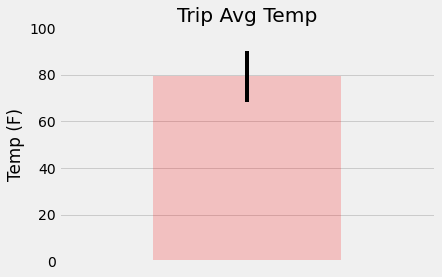

In [12]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
y = aug_temps[0][1]
errorbar = aug_temps[0][2]-aug_temps[0][0]
plt.bar(x=0.1, height=y, yerr=errorbar, width=.1, alpha=0.2, color="red")
plt.grid(axis='x')
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.xlim(0, .2)
plt.ylim(0,100)

#found code here to remove xticks: https://stackoverflow.com/questions/12998430/remove-xticks-in-a-matplotlib-plot
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

### Daily Rainfall Average

In [13]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
session.query(func.sum(Measurement.prcp), Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).group_by(Station.station).order_by(func.sum(Measurement.prcp).desc()).filter(Station.station == Measurement.station).filter(Measurement.date >= '2017-08-01').filter(Measurement.date <= '2017-08-07').all()

[(0.36, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4),
 (0.22, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (0.06, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (0.04, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (0.0, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)]

### Daily Temperature Normals

In [14]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
#daily_normals("01-01")

In [15]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
date_range = pd.date_range(start=start_date, end=end_date)
#print(date_range)

# Strip off the year and save a list of strings in the format %m-%d
edited_date_range = date_range.strftime('%m-%d')
#print(date_range)

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.

normals = []
for date in edited_date_range: 
    normals_dict = {}
    normals_dict["tmin"] = daily_normals(date)[0][0]
    normals_dict["tavg"] = daily_normals(date)[0][1]
    normals_dict["tmax"] = daily_normals(date)[0][2]
    normals.append(normals_dict)
    
#print(normals)

In [16]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(normals, columns=["tmin", "tavg", "tmax"])
date_list = []
for date in date_range:
    #reformating the dates to make the x axis labels stay in YYYY-MM-DD format
    date_list.append(date.strftime("%Y-%m-%d"))
df["date"] = date_list
df = df.set_index("date")

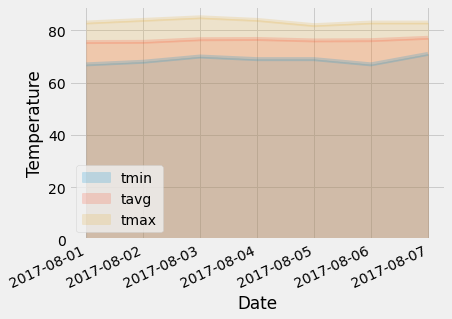

In [17]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot.area(stacked=False, xlabel="Date", ylabel="Temperature", rot=25, alpha=0.2)
plt.xticks(ha="right")
plt.show()

## Close Session

In [18]:
session.close()